<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [62]:
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use('fast')

import tensorflow as tf

print(f'Tensorflow version: {tf.__version__}')
print(f'GPU detected: {tf.config.list_physical_devices("GPU")}')

Tensorflow version: 2.1.0
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [63]:
data_path = Path('ner_dataset.csv.zip')
data = pd.read_csv(data_path, encoding='latin1')
data = data.fillna(method='ffill')

In [64]:
# lowercase columns
data.columns = data.columns.str.lower()

In [65]:
data.head(20)

,sentence #,word,pos,tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [66]:
print(f'Unique words in corpus: {data["word"].nunique()}')
print(f'Unique tags in corpus: {data["tag"].nunique()}')

Unique words in corpus: 35178
Unique tags in corpus: 17


In [67]:
words = list(set(data['word'].values))
words.append('ENDPAD')
num_words = len(words)

In [68]:
tags = list(set(data['tag'].values))
num_tags = len(tags)

In [69]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponding Tags

In [70]:
class SentenceGetter:
    def __init__(self, data):
        self.n_sent = 1
        self.data = data

        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['word'].values.tolist(),
                                                           s['pos'].values.tolist(),
                                                           s['tag'].values.tolist())]

        self.grouped = self.data.groupby('sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [71]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [72]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [73]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [74]:
word2idx


{'concerns': 1,
 'throw': 2,
 '33': 3,
 'Olympian': 4,
 'handing': 5,
 'Pakistani-controlled': 6,
 'pondered': 7,
 'Congress': 8,
 'Shandong': 9,
 'Warming': 10,
 'shows': 11,
 'regressing': 12,
 'AU': 13,
 'ransom': 14,
 'ailment': 15,
 'releases': 16,
 'multi-year': 17,
 'Decade': 18,
 'buyout': 19,
 'Traian': 20,
 'Maoist': 21,
 'leased': 22,
 'Foxx': 23,
 'demerits': 24,
 "O'Hara": 25,
 'Asir': 26,
 'Capital': 27,
 'week-and-a-half': 28,
 'Kan': 29,
 'hunted': 30,
 'Kunpeng': 31,
 'Situations': 32,
 'lightning': 33,
 'al-Juhyi': 34,
 'U.S.-proposed': 35,
 'Agreement': 36,
 'patients': 37,
 'reviewed': 38,
 'hunters': 39,
 'nursing': 40,
 'Minghe': 41,
 'Jaji': 42,
 'airing': 43,
 'traveling': 44,
 'Carson': 45,
 'Dixie': 46,
 'blanked': 47,
 'Plavia': 48,
 'angioplasty': 49,
 'sprain': 50,
 'warm-up': 51,
 'Durban': 52,
 'culpable': 53,
 'Baleno': 54,
 'flush': 55,
 'Macedonian': 56,
 'pizza': 57,
 'independent': 58,
 'director-general': 59,
 "Sa'eed": 60,
 'Bormio': 61,
 'Basuto':

### Task 5: Padding Input Sentences and Creating Train/Test Splits

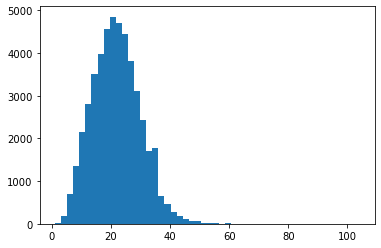

In [75]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [76]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(X, maxlen=max_len, padding='post', value=num_words-1)


y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(y, maxlen=max_len, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [77]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [78]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [79]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Task 7: Train the Model

In [81]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

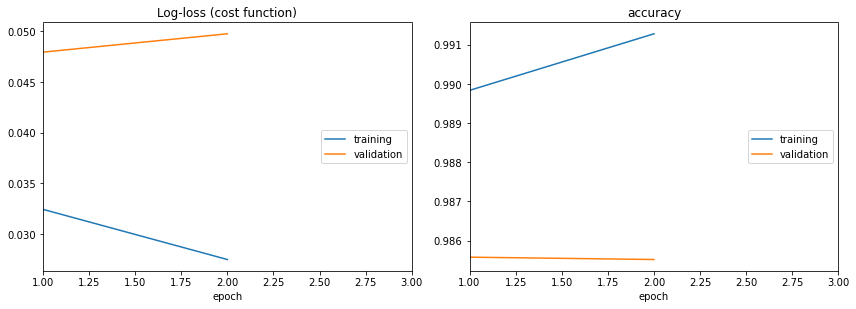

Log-loss (cost function):
training   (min:    0.027, max:    0.032, cur:    0.027)
validation (min:    0.048, max:    0.050, cur:    0.050)

accuracy:
training   (min:    0.990, max:    0.991, cur:    0.991)
validation (min:    0.986, max:    0.986, cur:    0.986)
30693/30693 [==============================] - 83s 3ms/sample - loss: 0.0275 - accuracy: 0.9913 - val_loss: 0.0497 - val_accuracy: 0.9855


In [89]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max',
                               restore_best_weights=False)
callbacks =[PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3, # for fast training
    verbose=1,
    callbacks=callbacks
)


### Task 8: Evaluate Named Entity Recognition Model

In [83]:
model.evaluate(x_test, np.array(y_test))

9592/9592 [==============================] - 4s 397us/sample - loss: 0.0513 - accuracy: 0.9848

[0.051348737819280295, 0.98483527]

In [88]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
print('-' * 30)

for w, true, pred in zip(x_test[i], y_true, p[0]):
    print(f'{words[w-1]:15}{tags[true]:5}\t{tags[pred]}')



Word           True 	 Pred

------------------------------
It             O    	O
says           O    	O
better         O    	O
economic       O    	O
conditions     O    	O
and            O    	O
remittances    O    	O
sent           O    	O
home           O    	O
by             O    	O
emigrants      O    	O
working        O    	O
abroad         O    	O
have           O    	O
contributed    O    	O
to             O    	O
the            O    	O
decline        O    	O
.              O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	O
smooth         O    	